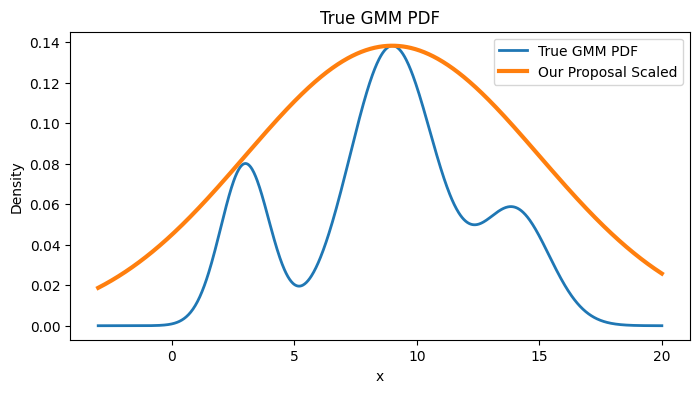

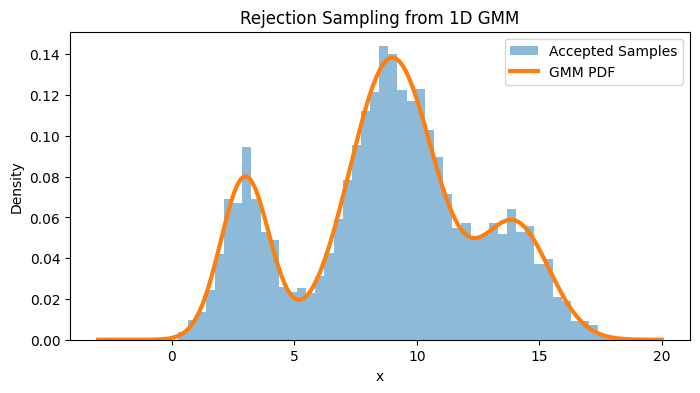



Estimated weights (a0, a1): [-0.27088849  0.53573307] 




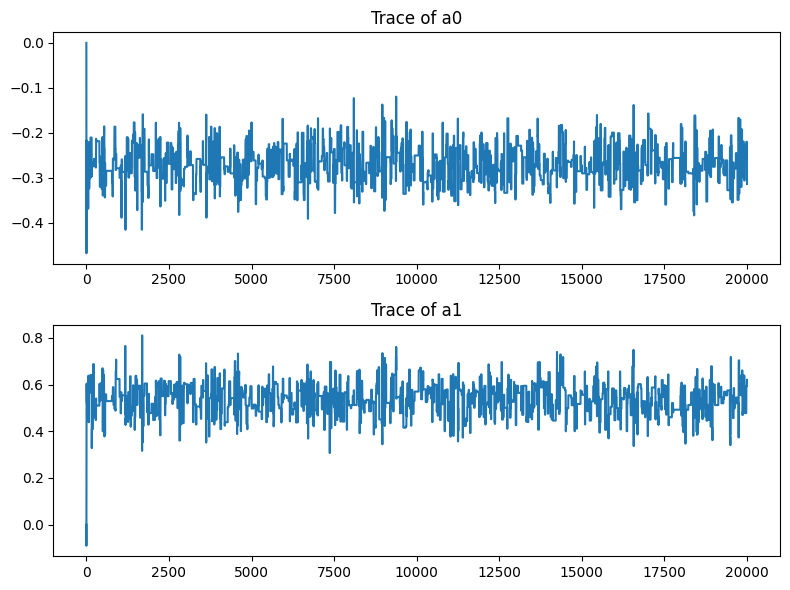

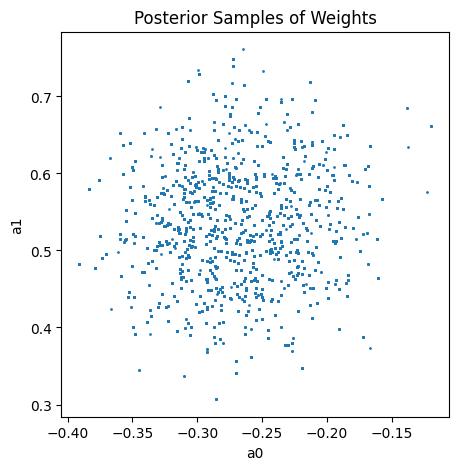

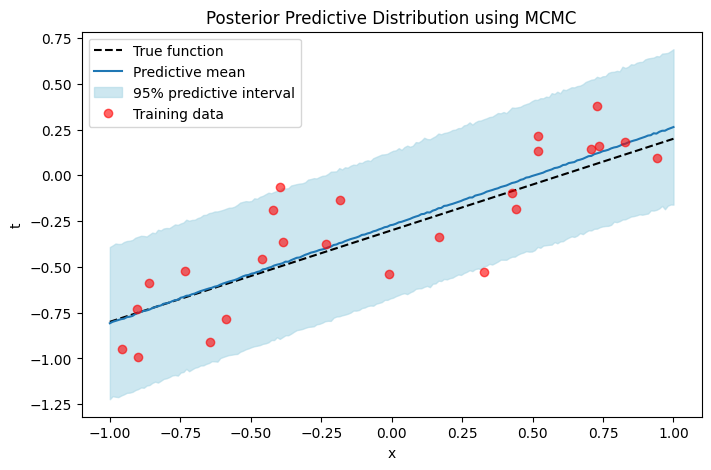

In [ ]:
# Project 6: Sampling Methods (Sheikh Islam, Wilson Jimenez, & Talha Akhlaq)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Part 1: Rejection Sampling

# Defining gaussian mixture model based off EM project
obs_means      = np.array([3.0,  9.0, 14.0])
obs_variances  = np.array([1.0,  3.0,  2.0])
obs_weights    = np.array([.2,  .6,  .2])

def gmm_pdf(x):  #Computing the PDF of the GMM at points x.
    x_arr = np.atleast_1d(x)
    pdf_vals = np.zeros_like(x_arr, dtype=float)
    for w, mu, sigma in zip(obs_weights, obs_means, np.sqrt(obs_variances)):
        pdf_vals += w * norm.pdf(x_arr, mu, sigma)
    return pdf_vals



# The proposal distribution is the standard normal
proposal = norm(9, 6)

# Estimating the envelope constant k to make sure p(z) ≤ kq(z) for all z
z_space = np.linspace(-6, 20, 10001)
k = np.max(gmm_pdf(z_space) / proposal.pdf(z_space))

#graphing proposal vs gmm
fig = plt.figure(figsize=(8, 4))
x_vals = np.linspace(-3, 20, 1000)
plt.plot(x_vals, gmm_pdf(x_vals), linewidth=2, label='True GMM PDF')
plt.plot(x_vals, k * proposal.pdf(x_vals), linewidth=3, label='Our Proposal Scaled')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('True GMM PDF')
plt.legend()
plt.show()

def rejection_sample_gmm(N): #function that does the rejection sampling
    samples = []
    batch_size = N
    while len(samples) < N: #loop ends when we have N samples accepted
        z0 = proposal.rvs(size=batch_size) # Sampling z0 from the proposal distribution q(z)
        q_z0 = proposal.pdf(z0)
        u0 = np.random.uniform(low=0., high=k*q_z0) # Sample u0 from Uniform[0, k q(z0)]
        pz0 = gmm_pdf(z0)    #evaluating our unkown pdf at z0
        accept = u0 <= pz0   # Accepting if u <= p(z0)
        samples.extend(z0[accept].tolist()) #keeps only the z0 values where accept is true

    return np.array(samples[:N])

# Generating samples
np.random.seed(42)
samples = rejection_sample_gmm(5000)

# Plotting the histogram against the GMM
x_vals = np.linspace(-3, 20, 1000)
plt.figure(figsize=(8, 4))
plt.hist(samples, bins=50, density=True, alpha=0.5, label='Accepted Samples')
plt.plot(x_vals, gmm_pdf(x_vals), linewidth=3, label='GMM PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Rejection Sampling from 1D GMM')
plt.legend()
plt.show()


# Part 2: MCMC Metropolis for Bayesian Linear Regression

N =25

#Setting the Initial Parameters: These paramaters can be found in pg.154 of the book and the same ones Bishop used for his figure.
np.random.seed(21)
alpha = 2.0
S0 = (1 / alpha) * np.eye(2)
m0 = np.zeros(2)
a0 = -0.3 #Intercept
a1 = 0.5 #Slope

beta = 25 #From the textbook

#Adding Our Noise to the Data
x_train = np.random.uniform(-1, 1, N)
t_train = a0 + a1 * x_train + np.random.normal(0, 1 / np.sqrt(beta), N)

# using log to deal with small values
def log_prior(w):
    # Choosing a guassian prior for w
    return norm.logpdf(w[0], 0, 1/np.sqrt(alpha)) + norm.logpdf(w[1], 0, 1/np.sqrt(alpha))

def log_likelihood(w): #using equation 3.10 as the likelihood function
    Phi = np.vstack((np.ones(N), x_train)).T
    y_prediction = Phi @ w
    return np.sum(norm.logpdf(t_train, y_prediction, 1/np.sqrt(beta)))#we use sum because we are using log

def log_posterior(w):
    return log_likelihood(w) + log_prior(w)

# Metropolis algorithm for sampling from posterior over weights
n = 20000
w_current = np.zeros(2)                    # Initializing current state of the chain
samples_mcmc = np.zeros((n, 2))       # storing the Markov chain
sigma_prop = 0.1 * np.eye(2)               # the Proposal covariance

for i in range(n):
    # Proposing new weights
    w_proposal = np.random.multivariate_normal(w_current, sigma_prop) #generating a sample
    p_current = log_posterior(w_current)
    p_proposal = log_posterior(w_proposal)
    u = np.random.rand()
    if np.log(u) < (p_proposal - p_current): # accepting the sample if A(z*, z(τ)) > u
    #the inequality simplifies to this beacuse of the log properties
        w_current = w_proposal #z(τ+1) = z*
    samples_mcmc[i] = w_current

# Discarding the initial samples from the chain
discard = int(0.2 * n)
posterior_samples = samples_mcmc[discard:] #keeping the samples drawn after discarding the first few
w_mean = posterior_samples.mean(axis=0) #getting the mean of the weights
print("\n\nEstimated weights (a0, a1):", w_mean, "\n\n")

# Plotting trace of each weight
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(samples_mcmc[:, 0])
plt.title('Trace of a0')
plt.subplot(2, 1, 2)
plt.plot(samples_mcmc[:, 1])
plt.title('Trace of a1')
plt.tight_layout()
plt.show()

# Creating a scatter plot of posterior samples
plt.figure(figsize=(5, 5))
plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1], s=1)
plt.xlabel('a0')
plt.ylabel('a1')
plt.title('Posterior Samples of Weights')
plt.show()


#STRETCH GOAL

x = np.linspace(-1, 1, 200)
Phi = np.vstack((np.ones_like(x), x)).T

#  Storing the results of the sampling process
n_posterior = len(posterior_samples)
predictive_samples = np.zeros((n_posterior, len(x)))

#implementign the two step algorithm described in the link
for i, w_sample in enumerate(posterior_samples): #taking w sample from the posterior
    # For each w_s we compute thr predictive mean for all x
    mu_pred = Phi @ w_sample

    # Drawing a sample of the new data from the likelihood distribution
    predictive_samples[i, :] = np.random.normal(mu_pred, 1/np.sqrt(beta))

predictive_mean = np.mean(predictive_samples, axis=0)
predictive_lower = np.percentile(predictive_samples, 2.5, axis=0)
predictive_upper = np.percentile(predictive_samples, 97.5, axis=0)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, a0 + a1*x, 'k--', label='True function')
plt.plot(x, predictive_mean, label='Predictive mean')
# 95% credible interval
plt.fill_between(x, predictive_lower, predictive_upper, color='lightblue', alpha=0.6, label='95% predictive interval')
plt.plot(x_train, t_train, 'ro', label='Training data', alpha=0.6)# Training data points
plt.xlabel('x')
plt.ylabel('t')
plt.title('Posterior Predictive Distribution using MCMC')
plt.legend()
plt.show()
